In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm

## Reload data after scANVI batch correction

In [3]:
data_path = Path(r"E:\ColorectalCancer\analysis\crc_data_pp_rounded_all_images")

In [4]:
exp = InSituExperiment.read(data_path)
exp.load_all()

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


In [5]:
# scanvi path
scanvi_path = Path(r"E:\ColorectalCancer\analysis\scANVI\results_gpu__celltypist_rounded_5000_1e2__majority_voting_simple__nb_gene-batch_100_50\scanvi.h5ad")
scanvi = sc.read(scanvi_path)

In [6]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...     Sample Name Metastasis type     H number              HE           panCK
0     3d377351  +++--      3621  Region_1-14...       1  ...  Colorectal ...             NaN  1414/18 IIA  C:\Users\ge...  C:\Users\ge...
1     039bf1f8  +++--      3621  Region_2-14...       2  ...  Lymph node ...     synchronous  1414/18 IIS  C:\Users\ge...  C:\Users\ge...
2     1c928862  +++--      3621  Region_3-33...       3  ...  Lung metast...    asynchronous  3311/18 IVA  C:\Users\ge...  C:\Users\ge...
3     18755ab6  +++--      3621  Region_4-14...       4  ...  Liver metas...     synchronous   1414/18 IC  C:\Users\ge...  C:\Users\ge...
4     3ee0776f  +++--      3991  Region_1-53...       1  ...  Colorectal ...             NaN  5316/18 IVC  C:\Users\ge...  C:\Users\ge...
5     4e08eb69  +++--      3991  Region_2-53...       2  ...  Lymph node ...     synchronous  5316/18 IVS  C:\Users\ge...  C:\Users\ge...
6

In [7]:
from insitupy.plotting import plot_overview

Saving figure to file figures/exp_overview.pdf
Saved.


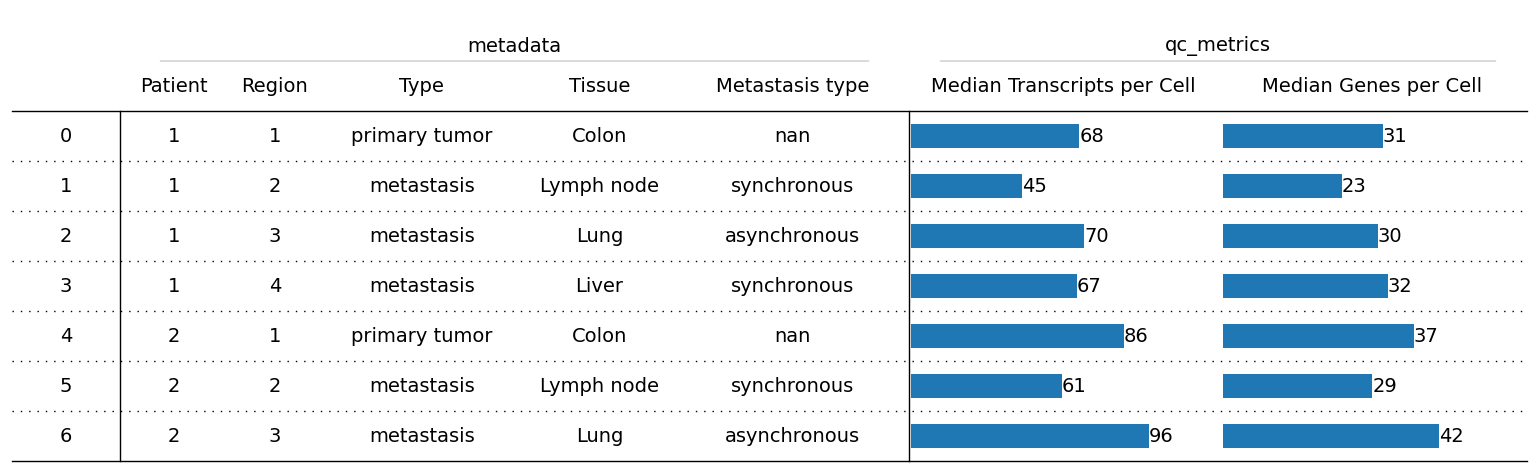

In [8]:
plot_overview(data=exp, cells_layer="proseg", colums_to_plot=["Patient", "Region", "Type", "Tissue", "Metastasis type"], savepath="figures/exp_overview.pdf")

### Transfer information from scANVI results to `InSituExperiment`

Remove uids from `obs_names` since this makes problems with saving. The string of the cell names may not be longer than <U10> (unicode string with maximum length of 10). 

In [9]:
scanvi.obs_names = [elem.split("-")[1] for elem in scanvi.obs_names]

Remove integer from uid column.

In [10]:
scanvi.obs["uid"] = [elem.split("-")[1] for elem in scanvi.obs["uid"]]

In [11]:
# xd = exp.data[0]
# meta = exp.metadata.iloc[0]
adata = scanvi

cells_layer = "proseg"
uid_column = "uid"
uid_column_anndata = "uid"
obs_columns_to_transfer = ["predicted_labels", "majority_voting", "majority_voting_simple"]
obsm_keys_to_transfer = ['X_pca', 'X_scANVI', 'X_scVI', 'X_umap', 'X_umap_scanvi', 'X_umap_scvi']
overwrite = False

for meta, xd in exp.iterdata():
    celldata = xd.cells[cells_layer]
    current_uid = meta[uid_column]
    mask = adata.obs[uid_column_anndata] == current_uid
    subset = adata[mask]
    for col in obs_columns_to_transfer:
        celldata.matrix.obs[col] = subset.obs[col]

    for key in obsm_keys_to_transfer:
        if key in celldata.matrix.obsm.keys() and not overwrite:
            raise ValueError(f"Key {key} already in `obsm.`. To ignore this, set `overwrite=True`.")
        celldata.matrix.obsm[key] = subset.obsm[key]

In [126]:
exp.show(0)

Viewer(camera=Camera(center=(0.0, np.float64(2906.04375), np.float64(3627.1625)), zoom=np.float64(0.04508040657312751), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(5812.0875), step=np.float64(0.2125)), RangeTuple(start=np.float64(0.0), stop=np.float64(7254.325), step=np.float64(0.2125))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(2905.9375), np.float64(3627.1625)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x1845732d300>, <Image layer 'HE' at 0x187df603e20>, <Image layer 'panCK' at 0x1876ec1feb0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0003621: Region_1-1

## Plot UMAP embedding

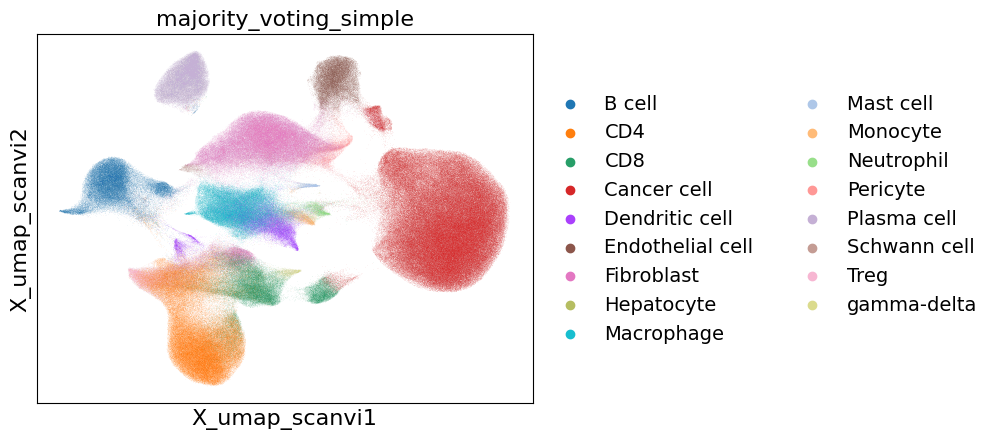

In [12]:
sc.pl.embedding(
    adata=scanvi, basis="X_umap_scanvi", color="majority_voting_simple",
    save="_majority_voting_simple.png"
)

## Save results

In [13]:
exp.save()

100%|██████████| 7/7 [03:09<00:00, 27.03s/it]
